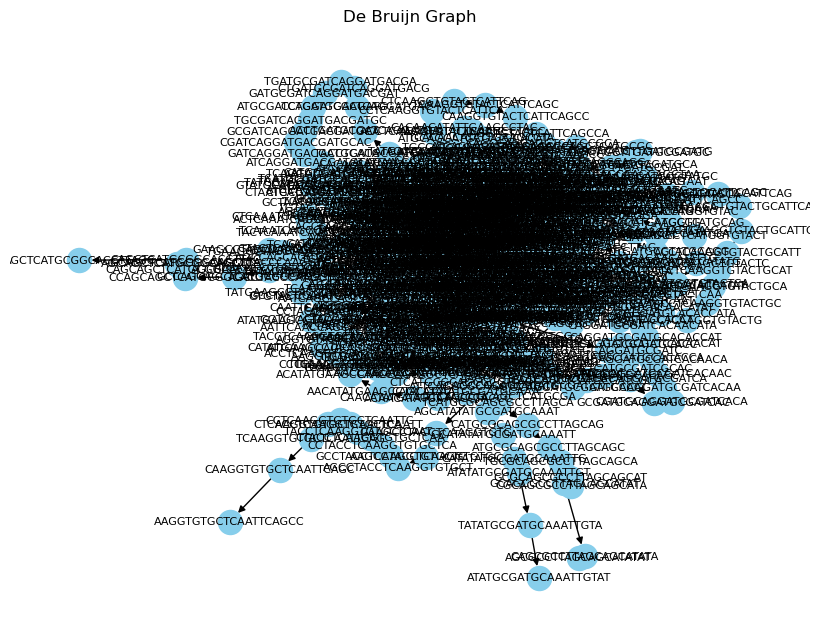

Number of contigs traced: 615


In [8]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# para generarGenera una secuencia de ADN aleatoria de una longitud dada y frecuencias de nucleótidos.
# :param length: Longitud de la secuencia de ADN.
#:param freq: Diccionario de frecuencias de nucleótidos.
#:return: Secuencia de ADN aleatoria como una cadena de texto.

def generate_random_dna(length, freq={'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}):
    if sum(freq.values()) != 1:
        raise ValueError("Nucleotide frequencies must sum to 1.")
    nucleotides = list(freq.keys())
    probabilities = list(freq.values())
    sequence = ''.join(random.choices(nucleotides, weights=probabilities, k=length))
    return sequence

#Agrega secuencias repetitivas en posiciones aleatorias de la secuencia de ADN.
#:param sequence: Secuencia de ADN original.
#:param repeat_seq: Secuencia a repetir.
#:param num_repeats: Número de veces que se insertará la secuencia repetida.
#:return: Secuencia de ADN con repeticiones añadidas.

def add_repeats(sequence, repeat_seq, num_repeats):
    for _ in range(num_repeats):
        insert_pos = random.randint(0, len(sequence))
        sequence = sequence[:insert_pos] + repeat_seq + sequence[insert_pos:]
    return sequence

#Simulacion del proceso de secuenciación, generando lecturas a partir de la secuencia de ADN.
#:param sequence: Secuencia de ADN a secuenciar.
#:param read_length: Longitud de cada lectura.
#:param coverage: Cobertura deseada de la secuenciación.
#:param error_rate: Probabilidad de errores de secuenciación en cada base.
#:return: Lista de lecturas de secuenciación.

def simulate_sequencing(sequence, read_length, coverage, error_rate):
    if read_length > len(sequence):
        raise ValueError("Read length must be less than or equal to the sequence length.")
    num_reads = int((len(sequence) * coverage) / read_length)
    reads = []
    for _ in range(num_reads):
        start_pos = random.randint(0, len(sequence) - read_length)
        read = sequence[start_pos:start_pos + read_length]
        read = introduce_errors(read, error_rate)
        reads.append(read)
    return reads

#Introduccion errores de secuenciación aleatorios en una lectura.
#:param read: Secuencia de lectura original.
#:param error_rate: Probabilidad de error en cada base.
#:return: Secuencia de lectura con errores introducidos.

def introduce_errors(read, error_rate):
    read_list = list(read)
    operations = ['substitute', 'insert', 'delete']
    i = 0
    while i < len(read_list):
        if random.random() < error_rate:
            operation = random.choice(operations)
            if operation == 'substitute':
                nucleotides = ['A', 'C', 'G', 'T']
                nucleotides.remove(read_list[i])
                read_list[i] = random.choice(nucleotides)
            elif operation == 'insert':
                nucleotide = random.choice(['A', 'C', 'G', 'T'])
                read_list.insert(i + 1, nucleotide)
                i += 1
            elif operation == 'delete' and len(read_list) > 1:  
                read_list.pop(i)
                continue
        i += 1
    return ''.join(read_list)

#Generacion k-mers a partir de una lista de lecturas de secuenciación.
#:param reads: Lista de lecturas de secuenciación.
#:param kmer_length: Longitud de los k-mers a generar.
#:return: Lista de k-mers.

def generate_kmers(reads, kmer_length):
    kmers = []
    for read in reads:
        for i in range(len(read) - kmer_length + 1):
            kmer = read[i:i + kmer_length]
            kmers.append(kmer)
    return kmers

#Construccion de un grafo de De Bruijn a partir de una lista de k-mers.
#:param kmers: Lista de k-mers.
#:return: Un grafo dirigido que representa el grafo de De Bruijn.

def construct_de_bruijn_graph(kmers):
    G = nx.DiGraph()
    for kmer in kmers:
        prefix = kmer[:-1]
        suffix = kmer[1:]
        G.add_edge(prefix, suffix)
    return G

#Rastrear contigs en el grafo de De Bruijn siguiendo rutas no ambiguas.
#:param G: Grafo de De Bruijn.
#:return: Lista de contigs como cadenas de texto.

def trace_contigs(G):
    contigs = []
    for node in G:
        if G.out_degree(node) == 1 and G.in_degree(node) == 1:
            if node not in contigs:
                contig = [node]
                current = node
                while True:
                    next_nodes = list(G.successors(current))
                    if len(next_nodes) != 1:
                        break
                    next_node = next_nodes[0]
                    if G.in_degree(next_node) != 1 or G.out_degree(next_node) != 1:
                        break
                    contig.append(next_node[-1])
                    current = next_node
                contigs.append(''.join(contig))
    return contigs

#Grafica el grafo de De Bruijn.
#:param G: Grafo de De Bruijn.

def plot_de_bruijn_graph(G):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, scale=2)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', width=1, font_size=8)
    plt.title('De Bruijn Graph')
    plt.show()

#Estimacion del número esperado de contigs basado en la ecuación de Lander-Waterman.
#:param genome_length: Longitud del genoma.
#:param read_length: Longitud de las lecturas de secuenciación.
#:param coverage: Cobertura de secuenciación.
#:return: Número esperado de contigs.

def lw_number_of_contigs(genome_length, read_length, coverage):
    read_count = coverage * (genome_length / read_length)
    expected_gaps = genome_length * (1 - (1 - (read_length / genome_length)) ** read_count)
    return expected_gaps

if __name__ == "__main__":
    sequence = generate_random_dna(100, {'A': 0.3, 'C': 0.2, 'G': 0.2, 'T': 0.3})
    sequence = add_repeats(sequence, 'ATGCGATGCA', 5)
    reads = simulate_sequencing(sequence, 100, 30, 0.01)
    kmers = generate_kmers(reads, 21)
    G = construct_de_bruijn_graph(kmers)
    contigs = trace_contigs(G)
    plot_de_bruijn_graph(G)
    print("Number of contigs traced:", len(contigs))


In [24]:
# Ejemplo del proceso de prueba con repeticiones
def test_assembly_with_lander_waterman(sequence_length, read_length, coverage, error_rate, repetitions=5):
    contig_counts = []
    lw_predictions = []
    
    for _ in range(repetitions):
        # Generacion sequencia random
        sequence = generate_random_dna(sequence_length)
        
        # Simulacion sequenciacion
        reads = simulate_sequencing(sequence, read_length, coverage, error_rate)
        
        # Generacion k-mers y construccion de De Bruijn grafico
        kmers = generate_kmers(reads, 21)
        G = construct_de_bruijn_graph(kmers)
        
        # Rastrear los contigs
        contigs = trace_contigs(G)
        contig_counts.append(len(contigs))
        
        # Calcular el número esperado de contigs utilizando la ecuación de Lander-Waterman
        lw_prediction = lw_number_of_contigs(sequence_length, read_length, coverage)
        lw_predictions.append(lw_prediction)
    
    # Calcular el promedio de contigs a partir de la ensambladura
    avg_contigs = sum(contig_counts) / repetitions
    avg_lw_prediction = sum(lw_predictions) / repetitions
    
    return avg_contigs, avg_lw_prediction

# Ejecutar pruebas con diferentes longitudes de secuencia, coberturas y tasas de error
sequence_lengths = [1000, 5000, 10000]
read_length = 100
coverage_levels = [10, 20, 30]
error_rates = [0.0, 0.01, 0.05]

# Finalmente, recopilo los resultados para cada combinacion
for seq_len in sequence_lengths:
    for cov in coverage_levels:
        for err in error_rates:
            avg_contigs, avg_lw = test_assembly_with_lander_waterman(seq_len, read_length, cov, err)
            print(f"Seq len: {seq_len}, Cov: {cov}, Error rate: {err}")
            print(f"  Avg contigs: {avg_contigs}, Avg L-W Prediction: {avg_lw}")


Seq len: 1000, Cov: 10, Error rate: 0.0
  Avg contigs: 951.8, Avg L-W Prediction: 999.9734386011125
Seq len: 1000, Cov: 10, Error rate: 0.01
  Avg contigs: 2229.6, Avg L-W Prediction: 999.9734386011125
Seq len: 1000, Cov: 10, Error rate: 0.05
  Avg contigs: 5550.4, Avg L-W Prediction: 999.9734386011125
Seq len: 1000, Cov: 20, Error rate: 0.0
  Avg contigs: 963.8, Avg L-W Prediction: 999.999999294492
Seq len: 1000, Cov: 20, Error rate: 0.01
  Avg contigs: 3537.6, Avg L-W Prediction: 999.999999294492
Seq len: 1000, Cov: 20, Error rate: 0.05
  Avg contigs: 9832.0, Avg L-W Prediction: 999.999999294492
Seq len: 1000, Cov: 30, Error rate: 0.0
  Avg contigs: 975.2, Avg L-W Prediction: 999.9999999999812
Seq len: 1000, Cov: 30, Error rate: 0.01
  Avg contigs: 4763.0, Avg L-W Prediction: 999.9999999999812
Seq len: 1000, Cov: 30, Error rate: 0.05
  Avg contigs: 14561.8, Avg L-W Prediction: 999.9999999999812
Seq len: 5000, Cov: 10, Error rate: 0.0
  Avg contigs: 4955.0, Avg L-W Prediction: 4999.79